In [1]:
import pandas as pd
from sklearn import linear_model
from sklearn import metrics
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import r2_score

# Funciones

In [25]:
def contar_palabras(titulo, palabras):
    
    contadas = 0
    
    for palabra in palabras:
        spliteado = titulo.split()
        contadas += spliteado.count(palabra)
        
    return contadas

def normalizar_descripciones(descripcion):
    
    descripcion = descripcion.replace(',', ' ')
    descripcion = descripcion.replace('.', ' ')
    descripcion = descripcion.replace('<', ' ')
    descripcion = descripcion.replace('>', ' ')
    descripcion = descripcion.replace('\n', ' ')
    descripcion = descripcion.replace('\strong', ' ')
    descripcion = descripcion.replace('\bold', ' ')
    descripcion = descripcion.lower()
    
    return descripcion

def mi_split (df):

    X = df.drop(['precio'], axis = 1)
    Y = df['precio']
    x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.35)
    return x_train, x_test, y_train, y_test

from scipy.stats import uniform, randint
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from sklearn import preprocessing

def minmax(serie):
    
    return (serie-serie.min())/(serie.max()-serie.min())

def mean_target_encoding(train, nombrefeat, nombretarget):
    
    temp = train.groupby(nombrefeat)[nombretarget].transform(np.mean)
    train[nombrefeat + "_mean"]=(temp-temp.min())/(temp.max()-temp.min())
    
    return train

def mean_target_decoding(x_test, nombrefeat, x_train):
    
    nombrefeatmean = nombrefeat + "_mean"
    
    temp = x_train.loc[:,[nombrefeat,nombrefeatmean]]
    temp = temp.set_index(nombrefeat)
    temp = temp.drop_duplicates()
    temp = temp.T.squeeze()
    values = x_test[nombrefeat].map(temp)
    x_test[nombrefeatmean] = values 

    return x_test

def armar_set_2(train):
    
    #Puedo resolver de forma general las que son iguales para train y test
    #es decir, aquellas que no filtran informacion a los de validacion
    
    train = train.drop(['descripcion', 'titulo', 'direccion', 'fecha', 'id'], axis = 1)
    
    #Adiciono servicios
    train['servicios'] = train['piscina'] + train['gimnasio'] + train['usosmultiples']
    
    #"Normalizo" la antiguedad
    #train['antiguedad'] = minmax(train['antiguedad'])
    
    #Elimino los residuos
    train = train.drop(['piscina', 'gimnasio','usosmultiples','escuelascercanas', 
                        'centroscomercialescercanos'], axis = 1)
    
    #Hago el split                    
    x_train, x_test, y_train, y_test = mi_split(train)
    
    x_train["precio"] = y_train
    x_test["precio"] = y_test
    
    df1 = x_train.dropna(subset=['metrostotales'])
    df1['preciometro']=df1['precio']/df1['metrostotales']

    PMM = df1.groupby('ciudad').agg({'preciometro': 'mean'})
    PMM = PMM.reset_index()
    PMM = PMM.rename(columns={"preciometro": "precioMetroMean"})

    x_train = x_train.merge(PMM, on='ciudad',how='left')
    x_test = x_test.merge(PMM, on='ciudad',how='left')
    


    df1 = x_train.dropna(subset=['metrostotales'])
    df1['preciometroCub']=df1['precio']/df1['metroscubiertos']

    PMM = df1.groupby('ciudad').agg({'preciometroCub': 'mean'})
    PMM = PMM.reset_index()
    PMM = PMM.rename(columns={"preciometroCub": "precioMetroCubMean"})

    x_train = x_train.merge(PMM, on='ciudad',how='left')
    x_test = x_test.merge(PMM, on='ciudad',how='left')
    
    
    
    df1 = x_train.dropna(subset=['metrostotales'])
    df1['preciometroDes']=df1['precio']/df1['metrosdescubiertos']

    PMM = df1.groupby('ciudad').agg({'preciometroDes': 'mean'})
    PMM = PMM.reset_index()
    PMM = PMM.rename(columns={"preciometroDes": "precioMetroDesMean"})

    x_train = x_train.merge(PMM, on='ciudad',how='left')
    x_test = x_test.merge(PMM, on='ciudad',how='left')
    
    #Calculo los mean target
    x_train_mean = mean_target_encoding(x_train, "provincia", "precio")
    x_train_mean['precio'] = y_train
    x_train_mean = mean_target_encoding(x_train_mean, "tipodepropiedad", "precio")
    x_train_mean = mean_target_encoding(x_train_mean, "ciudad", "precio")
    
    #Se los asigno a los test (NO LOS CALCULO CON ELLOS!!!!!!)
    x_test = mean_target_decoding(x_test, "provincia", x_train_mean)
    x_test = mean_target_decoding(x_test, "tipodepropiedad", x_train_mean)
    x_test = mean_target_decoding(x_test, "ciudad", x_train_mean)

    backup = x_train_mean
    
    x_train = x_train_mean.drop(["precio","provincia","tipodepropiedad","ciudad"], axis=1)
    x_test.drop(["precio","provincia","tipodepropiedad", "ciudad"], axis=1, inplace = True)

    
    return x_train, x_test, y_train, y_test, backup

In [29]:
df = pd.read_csv("./train.csv")

In [30]:
df['titulo'] = df['titulo'].fillna(value = ".")
df['titulo'] = df['titulo'].apply(normalizar_descripciones)
df['descripcion'] = df['descripcion'].fillna(value = ".")
df['descripcion'] = df['descripcion'].apply(normalizar_descripciones)

In [31]:
df['calefaccion'] = df['titulo'].apply(contar_palabras, palabras=["calefaccion", "calefacción", "calefaccionado", "aireacondicinado",
                    "acondicionado", "estufa","chimenea"]) +df['descripcion'].apply(contar_palabras, palabras=["calefaccion", 
                    "calefacción", "calefaccionado", "aireacondicinado", "acondicionado", "estufa","chimenea"])
df['suite'] = df['titulo'].apply(contar_palabras, palabras=["suite"])+df['descripcion'].apply(contar_palabras, palabras=["suite"])
df['avenida'] = df['titulo'].apply(contar_palabras, palabras=["avenida", "av", "avenidas", "bulevar", 
               "boulevard", "paseo", "vía"])+df['descripcion'].apply(contar_palabras, palabras=["avenida", "av", 
                "avenidas", "bulevar","boulevard", "paseo", "vía"])
df['gim'] = df['titulo'].apply(contar_palabras, palabras=["gimnasio", "gimnásio", "entrenamiento", "gim", "gym", "fit",
            "ejercicio", "gimnasia","atletismo", "cancha"])+df['descripcion'].apply(contar_palabras, palabras=["gimnasio",
            "gimnásio", "entrenamiento", "gim", "gym", "fit","ejercicio", "gimnasia","atletismo", "cancha"])
df['cochera'] = df['titulo'].apply(contar_palabras, palabras=["cochera", "cocheras", "garage", 
                "garages", "garaje", "garajes"])+df['descripcion'].apply(contar_palabras, palabras=["cochera", 
                "cocheras", "garage","garages", "garaje", "garajes"])
df['ubicacion'] = df['titulo'].apply(contar_palabras, palabras=["ubicacion", "ubicación", "locacion", 
                "locación", "localizacion", "localización","ubicado", "ubicada", "centro", "centrico",
                "centrica", "céntrico", "céntrica","central"])+df['descripcion'].apply(contar_palabras, palabras=["ubicacion", "ubicación", "locacion", 
                "locación", "localizacion", "localización","ubicado", "ubicada", "centro", "centrico",
                "centrica", "céntrico", "céntrica","central"])
df['balcon'] = df['titulo'].apply(contar_palabras, palabras=["balcon", "balcón", "terraza", "palco", "mirador", 
            "balconcillo","azotea", "solana"])+df['descripcion'].apply(contar_palabras, palabras=["balcon", "balcón", 
            "terraza", "palco", "mirador", "balconcillo","azotea", "solana"])
df['camaraseg'] = df['titulo'].apply(contar_palabras, palabras=["camara", "cámara", "cámaras", "camaras","seguridad",
                "guardia","seguro","protegido"]) + df['descripcion'].apply(contar_palabras, palabras=["camara", "cámara",
                "cámaras", "camaras","seguridad","guardia","seguro","protegido"])
df['parque'] = df['titulo'].apply(contar_palabras, palabras=["parque", "plaza", "plazoleta", "glorieta","jardin",
            "jardín","patio"])+df['descripcion'].apply(contar_palabras, palabras=["parque", "plaza", "plazoleta", 
            "glorieta","jardin","jardín","patio"])
df['amoblado'] = df['titulo'].apply(contar_palabras, palabras=["muebles", "amoblado", "mueble","decorado",
                "listo"]) + df['descripcion'].apply(contar_palabras, palabras=["muebles", "amoblado", "mueble",
                "decorado","listo"])
df['bañera'] = df['titulo'].apply(contar_palabras, palabras=["bañera", "hidromasaje", "hidro", "tina",
            "jacuzzi","jacuzi","yacuzi"]) + df['descripcion'].apply(contar_palabras, palabras=["bañera", "hidromasaje", 
            "hidro", "tina","jacuzzi","jacuzi","yacuzi"])
df['estreno'] = df['titulo'].apply(contar_palabras, palabras=["nuevo", "nueva", "estrenar","estreno",
            "innovador"]) + df['descripcion'].apply(contar_palabras, palabras=["nuevo", "nueva", "estrenar","estreno",
            "innovador"])
df['transporte'] = df['titulo'].apply(contar_palabras, palabras=["subte", "subterraneo", "subterráneo","metro", 
                "estacion", "estación", "tren","subestacion", "subestación", "ferrocarril","metrobús", "metrobus", 
                "trolebus","trolebús", "bus", "bús"]) + df['descripcion'].apply(contar_palabras, palabras=["subte", 
                "subterraneo", "subterráneo","metro", "estacion", "estación", "tren","subestacion", "subestación", 
                "ferrocarril","metrobús", "metrobus", "trolebus","trolebús", "bus", "bús"])
df['pileta'] = df['titulo'].apply(contar_palabras, palabras=["piscina", "pileta", "nado"])+ df['descripcion'].apply(contar_palabras, palabras=["piscina", "pileta", "nado"])
df['lujo'] = df['titulo'].apply(contar_palabras, palabras=["lujo", "delujo", "deluxe", "delúxe", "lujosa", "lujoso", 
            "lujosas", "lujosos","exclusivo","vip"]) + df['descripcion'].apply(contar_palabras, palabras=["lujo", 
            "delujo","deluxe", "delúxe", "lujosa", "lujoso", "lujosas", "lujosos","exclusivo","vip"])
df['humilde'] = df['titulo'].apply(contar_palabras, palabras=["humilde", "economico", "economica", 
            "económico", "económica", "barata", "barato", "accesible", "baratillo",
            "baratilla", "rebajado", "ganga", "asequible", "módico", "módica","credito","crédito","oferta","oferton",
            "imperdible"]) + df['descripcion'].apply(contar_palabras, palabras=["humilde", "economico", "economica", 
            "económico", "económica", "barata", "barato", "accesible", "baratillo",
            "baratilla", "rebajado", "ganga", "asequible", "módico", "módica",
            "credito","crédito","oferta","oferton","imperdible"])
df['ventana'] = df['titulo'].apply(contar_palabras, palabras=["ventana", "ventanas", 
            "vista", "ventanal","vistas","cristal"]) + df['descripcion'].apply(contar_palabras, palabras=["ventana",
            "ventanas", "vista", "ventanal","vistas","cristal"])
df['nuevo'] = df['titulo'].apply(contar_palabras, palabras=["reciente", "recien", "recién", "nueva", "nuevo", "nuevas", 
            "nuevos", "estrenar"]) + df['descripcion'].apply(contar_palabras, palabras=["reciente", "recien", "recién", 
            "nueva", "nuevo", "nuevas", "nuevos", "estrenar"])
df['luz'] = df['titulo'].apply(contar_palabras, palabras=["luz", "luminoso", "luminosa","claridad", "luminiscencia", 
        "luminosidad", "iluminación","iluminacion"]) + df['descripcion'].apply(contar_palabras, palabras=["luz", 
        "luminoso", "luminosa","claridad", "luminiscencia","luminosidad", "iluminación","iluminacion"])
df['bueno'] = df['titulo'].apply(contar_palabras, palabras=["bueno", "buena", "buenas", "buenos","excelente", 
            "excelentes","increible","espectacular","preciosos"]) + df['descripcion'].apply(contar_palabras, palabras=["bueno", 
            "buena", "buenas", "buenos","excelente", "excelentes","increible","espectacular","preciosos"])
df['contable'] = df['titulo'].apply(contar_palabras, palabras=["precio"]) + df['descripcion'].apply(contar_palabras, palabras=["precio"])

In [98]:
dfreducido = df.dropna()
x_train, x_test, y_train, y_test, backup = armar_set_2(dfreducido)

X,y = x_train, y_train
selector = SelectKBest(k='all').fit(X,y)
x_new = selector.transform(X)
scores = selector.scores_
columnas = x_train.columns

Text(0, 0.5, 'Score')

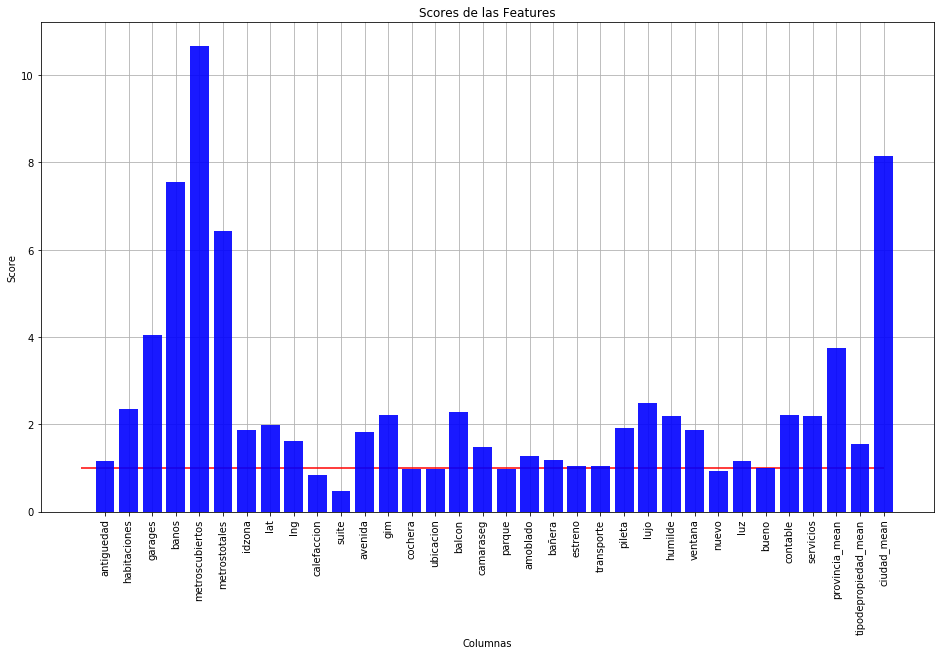

In [99]:
k_utilizado = np.arange(columnas.size)+1


plt.grid()
plt.bar(k_utilizado, scores, color = 'blue', align='center', alpha=0.9, zorder =3)
plt.xticks(k_utilizado, columnas, rotation=90)
fig = plt.gcf()
fig.set_size_inches(16, 9)
plt.hlines(1, xmin=0, xmax = 34,colors='red', linestyles='solid', label='')
plt.title("Scores de las Features")
plt.xlabel("Columnas")
plt.ylabel("Score")

In [100]:
from sklearn.model_selection import GridSearchCV, train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import r2_score

x_train, x_test, y_train, y_test, backup = armar_set_2(df)

In [ ]:
#Armo modelo

xgb_model = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, eval_metric='mae',
             gamma=0.015, importance_type='gain', learning_rate=0.026,
             max_delta_step=0, max_depth=11, min_child_weight=1, missing=None,
             n_estimators=1350, n_jobs=1, nthread=-1, objective='reg:linear',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.733, verbosity=1)


#Fitteo
xgb_model.fit(x_train, y_train)
prediccion = xgb_model.predict(x_test)
prediccion_anido = (prediccion + prediccion)/2

In [ ]:
#xhgbfeat4
print(mean_absolute_error(y_test, prediccion))

In [ ]:
#xgbfeat3
print(mean_absolute_error(y_test, prediccion_anido))

In [ ]:
#model

In [107]:
x_test = pd.read_csv("test.csv")

In [102]:
df = x_test

In [103]:
df['titulo'] = df['titulo'].fillna(value = ".")
df['titulo'] = df['titulo'].apply(normalizar_descripciones)
df['descripcion'] = df['descripcion'].fillna(value = ".")
df['descripcion'] = df['descripcion'].apply(normalizar_descripciones)

In [104]:
df['calefaccion'] = df['titulo'].apply(contar_palabras, palabras=["calefaccion", "calefacción", "calefaccionado", "aireacondicinado",
            "acondicionado", "estufa","chimenea"]) +df['descripcion'].apply(contar_palabras, palabras=["calefaccion", 
            "calefacción", "calefaccionado", "aireacondicinado", "acondicionado", "estufa","chimenea"])
df['suite'] = df['titulo'].apply(contar_palabras, palabras=["suite"])
df['avenida'] = df['titulo'].apply(contar_palabras, palabras=["avenida", "av", "avenidas", "bulevar", 
            "boulevard", "paseo", "vía"])+df['descripcion'].apply(contar_palabras, palabras=["avenida", "av", 
            "avenidas", "bulevar","boulevard", "paseo", "vía"])
df['gim'] = df['titulo'].apply(contar_palabras, palabras=["gimnasio", "gimnásio", "entrenamiento", "gim", "gym", "fit",
            "ejercicio", "gimnasia","atletismo", "cancha"])+df['descripcion'].apply(contar_palabras, palabras=["gimnasio",
            "gimnásio", "entrenamiento", "gim", "gym", "fit","ejercicio", "gimnasia","atletismo", "cancha"])
df['cochera'] = df['titulo'].apply(contar_palabras, palabras=["cochera", "cocheras", "garage", 
            "garages", "garaje", "garajes"])+df['descripcion'].apply(contar_palabras, palabras=["cochera", 
            "cocheras", "garage","garages", "garaje", "garajes"])
df['ubicacion'] = df['titulo'].apply(contar_palabras, palabras=["ubicacion", "ubicación", "locacion", 
            "locación", "localizacion", "localización","ubicado", "ubicada", "centro", "centrico",
            "centrica", "céntrico", "céntrica","central"])+df['descripcion'].apply(contar_palabras, palabras=["ubicacion", "ubicación", "locacion", 
            "locación", "localizacion", "localización","ubicado", "ubicada", "centro", "centrico",
            "centrica", "céntrico", "céntrica","central"])
df['balcon'] = df['titulo'].apply(contar_palabras, palabras=["balcon", "balcón", "terraza", "palco", "mirador", 
            "balconcillo","azotea", "solana"])+df['descripcion'].apply(contar_palabras, palabras=["balcon", "balcón", 
            "terraza", "palco", "mirador", "balconcillo","azotea", "solana"])
df['camaraseg'] = df['titulo'].apply(contar_palabras, palabras=["camara", "cámara", "cámaras", "camaras","seguridad",
            "guardia","seguro","protegido"]) + df['descripcion'].apply(contar_palabras, palabras=["camara", "cámara",
            "cámaras", "camaras","seguridad","guardia","seguro","protegido"])
df['parque'] = df['titulo'].apply(contar_palabras, palabras=["parque", "plaza", "plazoleta", "glorieta","jardin",
            "jardín","patio"])+df['descripcion'].apply(contar_palabras, palabras=["parque", "plaza", "plazoleta", 
            "glorieta","jardin","jardín","patio"])
df['amoblado'] = df['titulo'].apply(contar_palabras, palabras=["muebles", "amoblado", "mueble","decorado",
            "listo"]) + df['descripcion'].apply(contar_palabras, palabras=["muebles", "amoblado", "mueble",
            "decorado","listo"])
df['bañera'] = df['titulo'].apply(contar_palabras, palabras=["bañera", "hidromasaje", "hidro", "tina",
            "jacuzzi","jacuzi","yacuzi"]) + df['descripcion'].apply(contar_palabras, palabras=["bañera", "hidromasaje", 
            "hidro", "tina","jacuzzi","jacuzi","yacuzi"])
df['estreno'] = df['titulo'].apply(contar_palabras, palabras=["nuevo", "nueva", "estrenar","estreno",
            "innovador"]) + df['descripcion'].apply(contar_palabras, palabras=["nuevo", "nueva", "estrenar","estreno",
            "innovador"])
df['transporte'] = df['titulo'].apply(contar_palabras, palabras=["subte", "subterraneo", "subterráneo","metro", 
            "estacion", "estación", "tren","subestacion", "subestación", "ferrocarril","metrobús", "metrobus", 
            "trolebus","trolebús", "bus", "bús"]) + df['descripcion'].apply(contar_palabras, palabras=["subte", 
            "subterraneo", "subterráneo","metro", "estacion", "estación", "tren","subestacion", "subestación", 
            "ferrocarril","metrobús", "metrobus", "trolebus","trolebús", "bus", "bús"])
df['pileta'] = df['titulo'].apply(contar_palabras, palabras=["piscina", "pileta", "nado"])+ df['descripcion'].apply(contar_palabras, palabras=["piscina", "pileta", "nado"])
df['lujo'] = df['titulo'].apply(contar_palabras, palabras=["lujo", "delujo", "deluxe", "delúxe", "lujosa", "lujoso", 
            "lujosas", "lujosos","exclusivo","vip"]) + df['descripcion'].apply(contar_palabras, palabras=["lujo", 
            "delujo","deluxe", "delúxe", "lujosa", "lujoso", "lujosas", "lujosos","exclusivo","vip"])
df['humilde'] = df['titulo'].apply(contar_palabras, palabras=["humilde", "economico", "economica", 
            "económico", "económica", "barata", "barato", "accesible", "baratillo",
            "baratilla", "rebajado", "ganga", "asequible", "módico", "módica","credito","crédito","oferta","oferton",
            "imperdible"]) + df['descripcion'].apply(contar_palabras, palabras=["humilde", "economico", "economica", 
            "económico", "económica", "barata", "barato", "accesible", "baratillo",
            "baratilla", "rebajado", "ganga", "asequible", "módico", "módica",
            "credito","crédito","oferta","oferton","imperdible"])
df['ventana'] = df['titulo'].apply(contar_palabras, palabras=["ventana", "ventanas", 
            "vista", "ventanal","vistas","cristal"]) + df['descripcion'].apply(contar_palabras, palabras=["ventana",
            "ventanas", "vista", "ventanal","vistas","cristal"])
df['nuevo'] = df['titulo'].apply(contar_palabras, palabras=["reciente", "recien", "recién", "nueva", "nuevo", "nuevas", 
            "nuevos", "estrenar"]) + df['descripcion'].apply(contar_palabras, palabras=["reciente", "recien", "recién", 
            "nueva", "nuevo", "nuevas", "nuevos", "estrenar"])
df['luz'] = df['titulo'].apply(contar_palabras, palabras=["luz", "luminoso", "luminosa","claridad", "luminiscencia", 
            "luminosidad", "iluminación","iluminacion"]) + df['descripcion'].apply(contar_palabras, palabras=["luz", 
            "luminoso", "luminosa","claridad", "luminiscencia","luminosidad", "iluminación","iluminacion"])
df['bueno'] = df['titulo'].apply(contar_palabras, palabras=["bueno", "buena", "buenas", "buenos","excelente", 
            "excelentes","increible","espectacular"]) + df['descripcion'].apply(contar_palabras, palabras=["bueno", 
            "buena", "buenas", "buenos","excelente", "excelentes","increible","espectacular"])
df['contable'] = df['titulo'].apply(contar_palabras, palabras=["precio"]) + df['descripcion'].apply(contar_palabras, palabras=["precio"])

In [ ]:
x_test = df

In [ ]:
#Adiciono servicios
x_test['servicios'] = x_test['piscina'] + x_test['gimnasio'] + x_test['usosmultiples']

#"Normalizo" la antiguedad
#x_train['antiguedad'] = minmax(x_train['antiguedad'])

#Se los asigno a los test (NO LOS CALCULO CON ELLOS!!!!!!)
x_test = mean_target_decoding(x_test, "provincia", backup)
x_test = mean_target_decoding(x_test, "tipodepropiedad", backup)
x_test = mean_target_decoding(x_test, "ciudad", backup)

#Elimino los residuos
x_test = x_test.drop(['piscina', 'gimnasio','usosmultiples','escuelascercanas', 'fecha',
                  'centroscomercialescercanos', 'titulo', 'direccion', 'descripcion',
                  'id'], axis = 1)

########### LIMPIO LOS QUE HICE MEAN ################

x_test.drop(["provincia", "tipodepropiedad","ciudad"], axis=1, inplace = True)

In [ ]:
prediccion = xgb_model.predict(x_test)

In [ ]:
test_original = pd.read_csv("test.csv")
predicciones = test_original.loc[:, ['id','ciudad']]
predicciones.rename(columns = {'ciudad' : 'target'}, inplace = True)
predicciones['target'] = prediccion
predicciones = predicciones.set_index('id')

In [ ]:
predicciones.to_csv(r'prediccionXGBfeat5.csv')

# Metros 

In [32]:
df1 = df
df1['metrosdescubiertos'] = abs(df1['metrostotales']-df1['metroscubiertos'])
df1['relacionmetros'] = df1['metrostotales']/df1['metroscubiertos']

In [33]:
df1['agregados']= df['escuelascercanas']+df['gimnasio']+df['centroscomercialescercanos']+df['piscina']+df['usosmultiples']
train = df1.drop(['id','idzona','lat','descripcion','titulo','lng', 'escuelascercanas','gimnasio','centroscomercialescercanos','piscina','usosmultiples'],1)
train['fecha'] = pd.to_datetime(train['fecha']).dt.year

X = train
y = train['precio']

from sklearn.model_selection import train_test_split
#Separo los datos de "train" en entrenamiento y prueba para probar los algoritmos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [34]:
X_train = X_train.drop(['precio','tipodepropiedad','provincia','ciudad','direccion'],1) 
X_test = X_test.drop(['precio','tipodepropiedad','provincia','ciudad','direccion'],1) 


#Armo modelo

xgb_model = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, eval_metric='mae',
             gamma=0.015, importance_type='gain', learning_rate=0.026,
             max_delta_step=0, max_depth=11, min_child_weight=1, missing=None,
             n_estimators=1350, n_jobs=1, nthread=-1, objective='reg:linear',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.733, verbosity=1)


#Fitteo
xgb_model.fit(X_train, y_train)
prediccion = xgb_model.predict(X_test)

/home/giaco/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:08:03] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Text(0, 0.5, 'Score')

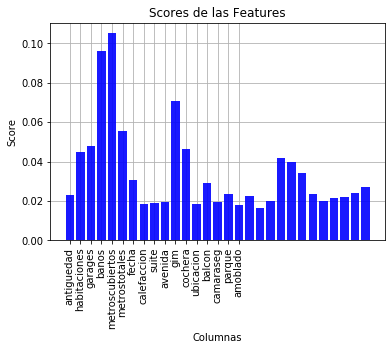

In [35]:
columnas = X_train.columns
k_utilizado = np.arange(17)
scores = xgb_model.feature_importances_
plt.grid()
plt.xticks(k_utilizado, columnas, rotation=90)
plt.bar(columnas, scores, color = 'blue', align='center', alpha=0.9, zorder =3)
plt.title("Scores de las Features")
plt.xlabel("Columnas")
plt.ylabel("Score")

In [36]:
print('MAE: ', metrics.mean_absolute_error(y_test, prediccion))

MAE:  841699.3686978352


In [ ]:
MAE:  572729.0019012858 con todo

In [11]:
df = pd.read_csv("./train.csv")

In [12]:
def contar_palabras(titulo, palabras):
    
    contadas = 0
    
    for palabra in palabras:
        spliteado = titulo.split()
        contadas += spliteado.count(palabra)
        
    return contadas

def normalizar_descripciones(descripcion):
    
    descripcion = descripcion.replace(',', ' ')
    descripcion = descripcion.replace('.', ' ')
    descripcion = descripcion.replace('<', ' ')
    descripcion = descripcion.replace('>', ' ')
    descripcion = descripcion.replace('\n', ' ')
    descripcion = descripcion.replace('\strong', ' ')
    descripcion = descripcion.replace('\bold', ' ')
    descripcion = descripcion.lower()
    
    return descripcion

def mi_split (df):

    X = df.drop(['precio'], axis = 1)
    Y = df['precio']
    x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.35)
    return x_train, x_test, y_train, y_test

from scipy.stats import uniform, randint
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from sklearn import preprocessing

def minmax(serie):
    
    return (serie-serie.min())/(serie.max()-serie.min())

def mean_target_encoding(train, nombrefeat, nombretarget):
    
    temp = train.groupby(nombrefeat)[nombretarget].transform(np.mean)
    train[nombrefeat + "_mean"]=(temp-temp.min())/(temp.max()-temp.min())
    
    return train

def mean_target_decoding(x_test, nombrefeat, x_train):
    
    nombrefeatmean = nombrefeat + "_mean"
    
    temp = x_train.loc[:,[nombrefeat,nombrefeatmean]]
    temp = temp.set_index(nombrefeat)
    temp = temp.drop_duplicates()
    temp = temp.T.squeeze()
    values = x_test[nombrefeat].map(temp)
    x_test[nombrefeatmean] = values 

    return x_test

def armar_set_2(train):
    
    #Puedo resolver de forma general las que son iguales para train y test
    #es decir, aquellas que no filtran informacion a los de validacion
    
    train = train.drop(['descripcion', 'titulo', 'direccion', 'fecha', 'id'], axis = 1)
    
    #Adiciono servicios
    train['servicios'] = train['piscina'] + train['gimnasio'] + train['usosmultiples']
    
    #"Normalizo" la antiguedad
    #train['antiguedad'] = minmax(train['antiguedad'])
    
    #Elimino los residuos
    train = train.drop(['piscina', 'gimnasio','usosmultiples','escuelascercanas', 
                        'centroscomercialescercanos'], axis = 1)
    
    #Hago el split                    
    x_train, x_test, y_train, y_test = mi_split(train)
        
    x_train["precio"] = y_train

    
    #Calculo los mean target
    x_train_mean = mean_target_encoding(x_train, "provincia", "precio")
    x_train_mean['precio'] = y_train
    x_train_mean = mean_target_encoding(x_train_mean, "tipodepropiedad", "precio")
    x_train_mean = mean_target_encoding(x_train_mean, "ciudad", "precio")
    
    #Se los asigno a los test (NO LOS CALCULO CON ELLOS!!!!!!)
    x_test = mean_target_decoding(x_test, "provincia", x_train_mean)
    x_test = mean_target_decoding(x_test, "tipodepropiedad", x_train_mean)
    x_test = mean_target_decoding(x_test, "ciudad", x_train_mean)

    backup = x_train_mean
    
    x_train = x_train_mean.drop(["precio","provincia","tipodepropiedad","ciudad"], axis=1)
    x_test.drop(["provincia","tipodepropiedad", "ciudad"], axis=1, inplace = True)

    
    return x_train, x_test, y_train, y_test, backup

In [13]:
df['titulo'] = df['titulo'].fillna(value = ".")
df['titulo'] = df['titulo'].apply(normalizar_descripciones)
df['descripcion'] = df['descripcion'].fillna(value = ".")
df['descripcion'] = df['descripcion'].apply(normalizar_descripciones)

In [14]:
df['calefaccion'] = df['titulo'].apply(contar_palabras, palabras=["calefaccion", "calefacción", "calefaccionado", "aireacondicinado",
                    "acondicionado", "estufa","chimenea"]) +df['descripcion'].apply(contar_palabras, palabras=["calefaccion", 
                    "calefacción", "calefaccionado", "aireacondicinado", "acondicionado", "estufa","chimenea"])
df['suite'] = df['titulo'].apply(contar_palabras, palabras=["suite"])+df['descripcion'].apply(contar_palabras, palabras=["suite"])
df['avenida'] = df['titulo'].apply(contar_palabras, palabras=["avenida", "av", "avenidas", "bulevar", 
               "boulevard", "paseo", "vía"])+df['descripcion'].apply(contar_palabras, palabras=["avenida", "av", 
                "avenidas", "bulevar","boulevard", "paseo", "vía"])
df['gim'] = df['titulo'].apply(contar_palabras, palabras=["gimnasio", "gimnásio", "entrenamiento", "gim", "gym", "fit",
            "ejercicio", "gimnasia","atletismo", "cancha"])+df['descripcion'].apply(contar_palabras, palabras=["gimnasio",
            "gimnásio", "entrenamiento", "gim", "gym", "fit","ejercicio", "gimnasia","atletismo", "cancha"])
df['cochera'] = df['titulo'].apply(contar_palabras, palabras=["cochera", "cocheras", "garage", 
                "garages", "garaje", "garajes"])+df['descripcion'].apply(contar_palabras, palabras=["cochera", 
                "cocheras", "garage","garages", "garaje", "garajes"])
df['ubicacion'] = df['titulo'].apply(contar_palabras, palabras=["ubicacion", "ubicación", "locacion", 
                "locación", "localizacion", "localización","ubicado", "ubicada", "centro", "centrico",
                "centrica", "céntrico", "céntrica","central"])+df['descripcion'].apply(contar_palabras, palabras=["ubicacion", "ubicación", "locacion", 
                "locación", "localizacion", "localización","ubicado", "ubicada", "centro", "centrico",
                "centrica", "céntrico", "céntrica","central"])
df['balcon'] = df['titulo'].apply(contar_palabras, palabras=["balcon", "balcón", "terraza", "palco", "mirador", 
            "balconcillo","azotea", "solana"])+df['descripcion'].apply(contar_palabras, palabras=["balcon", "balcón", 
            "terraza", "palco", "mirador", "balconcillo","azotea", "solana"])
df['camaraseg'] = df['titulo'].apply(contar_palabras, palabras=["camara", "cámara", "cámaras", "camaras","seguridad",
                "guardia","seguro","protegido"]) + df['descripcion'].apply(contar_palabras, palabras=["camara", "cámara",
                "cámaras", "camaras","seguridad","guardia","seguro","protegido"])
df['parque'] = df['titulo'].apply(contar_palabras, palabras=["parque", "plaza", "plazoleta", "glorieta","jardin",
            "jardín","patio"])+df['descripcion'].apply(contar_palabras, palabras=["parque", "plaza", "plazoleta", 
            "glorieta","jardin","jardín","patio"])
df['amoblado'] = df['titulo'].apply(contar_palabras, palabras=["muebles", "amoblado", "mueble","decorado",
                "listo"]) + df['descripcion'].apply(contar_palabras, palabras=["muebles", "amoblado", "mueble",
                "decorado","listo"])
df['bañera'] = df['titulo'].apply(contar_palabras, palabras=["bañera", "hidromasaje", "hidro", "tina",
            "jacuzzi","jacuzi","yacuzi"]) + df['descripcion'].apply(contar_palabras, palabras=["bañera", "hidromasaje", 
            "hidro", "tina","jacuzzi","jacuzi","yacuzi"])
df['estreno'] = df['titulo'].apply(contar_palabras, palabras=["nuevo", "nueva", "estrenar","estreno",
            "innovador"]) + df['descripcion'].apply(contar_palabras, palabras=["nuevo", "nueva", "estrenar","estreno",
            "innovador"])
df['transporte'] = df['titulo'].apply(contar_palabras, palabras=["subte", "subterraneo", "subterráneo","metro", 
                "estacion", "estación", "tren","subestacion", "subestación", "ferrocarril","metrobús", "metrobus", 
                "trolebus","trolebús", "bus", "bús"]) + df['descripcion'].apply(contar_palabras, palabras=["subte", 
                "subterraneo", "subterráneo","metro", "estacion", "estación", "tren","subestacion", "subestación", 
                "ferrocarril","metrobús", "metrobus", "trolebus","trolebús", "bus", "bús"])
df['pileta'] = df['titulo'].apply(contar_palabras, palabras=["piscina", "pileta", "nado"])+ df['descripcion'].apply(contar_palabras, palabras=["piscina", "pileta", "nado"])
df['lujo'] = df['titulo'].apply(contar_palabras, palabras=["lujo", "delujo", "deluxe", "delúxe", "lujosa", "lujoso", 
            "lujosas", "lujosos","exclusivo","vip"]) + df['descripcion'].apply(contar_palabras, palabras=["lujo", 
            "delujo","deluxe", "delúxe", "lujosa", "lujoso", "lujosas", "lujosos","exclusivo","vip"])
df['humilde'] = df['titulo'].apply(contar_palabras, palabras=["humilde", "economico", "economica", 
            "económico", "económica", "barata", "barato", "accesible", "baratillo",
            "baratilla", "rebajado", "ganga", "asequible", "módico", "módica","credito","crédito","oferta","oferton",
            "imperdible"]) + df['descripcion'].apply(contar_palabras, palabras=["humilde", "economico", "economica", 
            "económico", "económica", "barata", "barato", "accesible", "baratillo",
            "baratilla", "rebajado", "ganga", "asequible", "módico", "módica",
            "credito","crédito","oferta","oferton","imperdible"])
df['ventana'] = df['titulo'].apply(contar_palabras, palabras=["ventana", "ventanas", 
            "vista", "ventanal","vistas","cristal"]) + df['descripcion'].apply(contar_palabras, palabras=["ventana",
            "ventanas", "vista", "ventanal","vistas","cristal"])
df['nuevo'] = df['titulo'].apply(contar_palabras, palabras=["reciente", "recien", "recién", "nueva", "nuevo", "nuevas", 
            "nuevos", "estrenar"]) + df['descripcion'].apply(contar_palabras, palabras=["reciente", "recien", "recién", 
            "nueva", "nuevo", "nuevas", "nuevos", "estrenar"])
df['luz'] = df['titulo'].apply(contar_palabras, palabras=["luz", "luminoso", "luminosa","claridad", "luminiscencia", 
        "luminosidad", "iluminación","iluminacion"]) + df['descripcion'].apply(contar_palabras, palabras=["luz", 
        "luminoso", "luminosa","claridad", "luminiscencia","luminosidad", "iluminación","iluminacion"])
df['bueno'] = df['titulo'].apply(contar_palabras, palabras=["bueno", "buena", "buenas", "buenos","excelente", 
            "excelentes","increible","espectacular","preciosos"]) + df['descripcion'].apply(contar_palabras, palabras=["bueno", 
            "buena", "buenas", "buenos","excelente", "excelentes","increible","espectacular","preciosos"])
df['contable'] = df['titulo'].apply(contar_palabras, palabras=["precio"]) + df['descripcion'].apply(contar_palabras, palabras=["precio"])

In [26]:
dfreducido = df.dropna()
x_train, x_test, y_train, y_test, backup = armar_set_2(dfreducido)

X,y = x_train, y_train
selector = SelectKBest(k='all').fit(X,y)
x_new = selector.transform(X)
scores = selector.scores_
columnas = x_train.columns

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

Text(0, 0.5, 'Score')

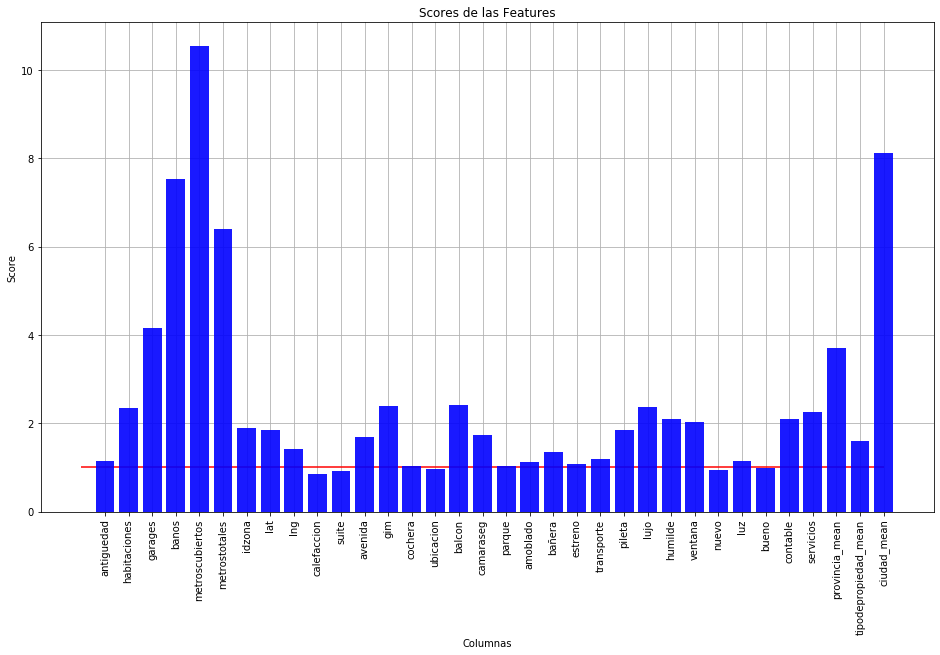

In [16]:
k_utilizado = np.arange(columnas.size)+1


plt.grid()
plt.bar(k_utilizado, scores, color = 'blue', align='center', alpha=0.9, zorder =3)
plt.xticks(k_utilizado, columnas, rotation=90)
fig = plt.gcf()
fig.set_size_inches(16, 9)
plt.hlines(1, xmin=0, xmax = 34,colors='red', linestyles='solid', label='')
plt.title("Scores de las Features")
plt.xlabel("Columnas")
plt.ylabel("Score")

In [17]:
df['metrosdescubiertos'] = abs(df['metrostotales']-df['metroscubiertos'])
df['relacionmetros'] = df['metrostotales']/df['metroscubiertos']

In [27]:
from sklearn.model_selection import GridSearchCV, train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import r2_score

x_train, x_test, y_train, y_test, backup = armar_set_2(df)

/home/giaco/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/giaco/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/giaco/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stabl

In [31]:
#Armo modelo

xgb_model = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, eval_metric='mae',
             gamma=0.015, importance_type='gain', learning_rate=0.026,
             max_delta_step=0, max_depth=11, min_child_weight=1, missing=None,
             n_estimators=1700, n_jobs=1, nthread=-1, objective='reg:linear',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.733, verbosity=1)


#Fitteo
xgb_model.fit(x_train, y_train)
prediccion = xgb_model.predict(x_test)
prediccion_anido = (prediccion + prediccion)/2

/home/giaco/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[22:24:45] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [32]:
print(mean_absolute_error(y_test, prediccion))

541504.0288235677
